# In group variablilty of WRs:
- Use ERA5 EDA control member
- Calculate composite z map
- Calculate variance at each grid point across all WR occurrences
- Compare to composites of uncertainty

In [13]:
source("../RScripts/config.r")
source("../RScripts/plot_functions.r")
source("../RScripts/data_functions.r")
source("../RScripts/algo_functions.r")


options(repr.plot.width = 15, repr.plot.height = 10) # Adjust width & height


In [3]:
result <- wrera(
    start = "19500111_00",
    end = "20250113_21",
    hours = c("00", "06", "12", "18"),
    tformat = "string",
    setup = "z500anom_1979_2019_on_wrdef_10d_1.0_1979_2019",
    dataset = "era5",
    basepath = "../WR_read_example_package/wr_era5_update_1950_latwgt/"
)

wr_df <- result$data$LC %>%
    filter(grepl("12$", time))
wr_df$date <- as.Date(wr_df$time, format = "%Y%m%d_%H")
tail(wr_df)


tsince,time,wrindex,wrname,date
<int>,<chr>,<int>,<chr>,<date>
403428,20250108_12,3,GL,2025-01-08
403452,20250109_12,3,GL,2025-01-09
403476,20250110_12,3,GL,2025-01-10
403500,20250111_12,0,no,2025-01-11
403524,20250112_12,0,no,2025-01-12
403548,20250113_12,0,no,2025-01-13


In [4]:
# Get the z_control data
nc <- nc_open("../ens_data/data.nc")

num <- ncvar_get(nc, "number")
number_idx <- which(num == 0)
number_idx <- number_idx[1]
lon <- ncvar_get(nc, "longitude")
lat <- ncvar_get(nc, "latitude")
time_data <- ncvar_get(nc, "valid_time")
time_origin <- sub(
    "seconds since ", "",
    ncatt_get(nc, "valid_time", "units")$value
)
time_whole <- as.Date(as.POSIXct(time_data,
    origin = time_origin,
    tz = "UTC"
))

start_vec <- c(1, 1, 1, number_idx)
count_vec <- c(-1, -1, -1, 1)
z_control <- ncvar_get(nc, "z", start = start_vec, count = count_vec)

nc_close(nc)


In [ ]:
z_comp <- calculate_wr_composites(z_control, time_whole, lon, lat, wr_df,
    calculate_variance = TRUE, n_perm = 100, n_cores = 10
)
z_comp$wr <- z_comp$wrindex
z_comp$p_value_adj <- p.adjust(z_comp$pval, method = "fdr")


In [3]:
z_comp <- readRDS("../ens_data/VarianceComposite.RDS")

str(z_comp)


Classes ‘data.table’ and 'data.frame':	271848 obs. of  9 variables:
 $ z          : num  51293 51288 51285 51280 51276 ...
 $ lon        : num  -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 ...
 $ lat        : num  90 89.5 89 88.5 88 87.5 87 86.5 86 85.5 ...
 $ wrindex    : Factor w/ 8 levels "1","6","7","2",..: 8 8 8 8 8 8 8 8 8 8 ...
 $ wrname     : Factor w/ 8 levels "AT","ZO","ScTr",..: 8 8 8 8 8 8 8 8 8 8 ...
 $ z_var      : num  -105635 -109989 -115818 -121659 -127653 ...
 $ pval       : num  0.774 0.793 0.82 0.846 0.865 ...
 $ wr         : Factor w/ 8 levels "1","6","7","2",..: 8 8 8 8 8 8 8 8 8 8 ...
 $ p_value_adj: num  1 1 1 1 1 1 1 1 1 1 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [7]:
pps <- grid_and_legend(z_comp,
    var = "z_var", sig_name = "pval", alpha = .05,
    clims = c(min(z_comp$z_var, na.rm = TRUE), max(z_comp$z_var, na.rm = TRUE))
)
p <- combine_plots(pps[[1]], pps[[2]], "horizontal")
save_plot(p, "RegimesVarianceLargeH.pdf", width = 11.5, height = 5.5)


Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven ho

pdf 
  2

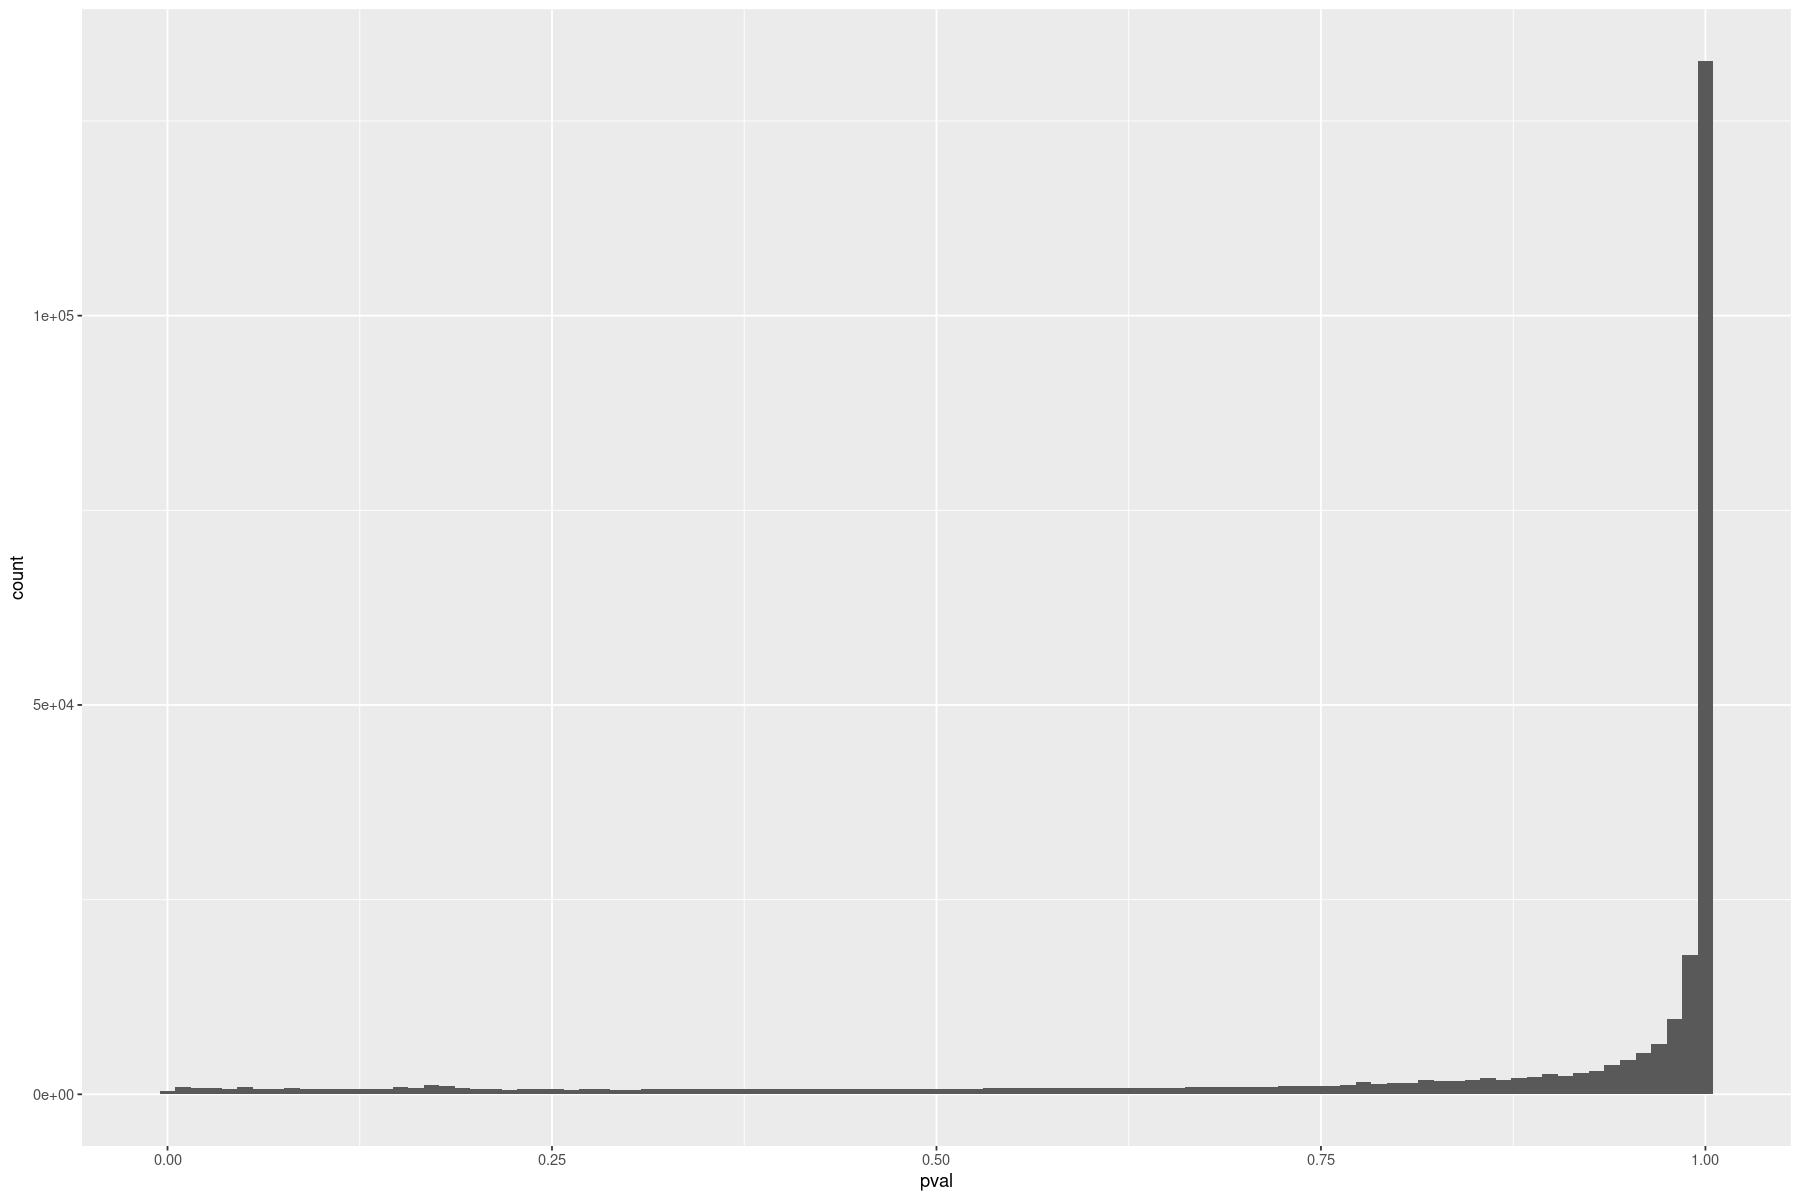

In [ ]:
# p-values make no sense as I calculated them
# They are the probability that the in-group variance is larger than the
# total dataset variance, which usually should be large
# 1-pval is more reasonable, but must be fdr adjusted. It is the probability
# that in-group variability is significantly smaller than total group
# variability
ggplot(z_comp, aes(x = pval)) +
    geom_histogram(bins = 100)


In [14]:
pps <- grid_and_legend(z_comp,
    var = "z_var", sig_name = "pval", alpha = 2,
    clims = c(min(z_comp$z_var, na.rm = TRUE), max(z_comp$z_var, na.rm = TRUE)),
    legend_name = "$(m^{2}s^{-2})^{2}$"
)
p <- combine_plots(pps[[1]], pps[[2]], "horizontal")
save_plot(p, "RegimesVarianceLargeH.pdf", width = 11.5, height = 5.5)


pdf 
  2

# What do Composites look like withoout the LMs?

In [44]:
raw_comp$wrindex %>% unique()


[1] 0 4 5 1 2 3 7 6
Levels: 0 1 2 3 4 5 6 7

In [1]:
raw_comp <- readRDS("../ens_data/Raw_WR_Comp.RDS")
head(raw_comp)


,segment,wrindex,mean,p_val,lat,lon
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,4.404137,NA,20,-100
2,0,0,4.445740,0.0260,20,-100
3,0,4,4.372464,0.4435,20,-100
4,0,5,4.252554,0.0005,20,-100
5,0,1,4.373508,0.4732,20,-100
6,0,2,4.461925,0.1561,20,-100


In [40]:
raw_comp <- raw_comp %>% left_join(z_comp %>% select(lon, lat, wrindex, z),
    by = c("lon" = "lon", "lat" = "lat", "wrindex" = "wrindex")
)
head(raw_comp)


In [41]:
total_means <- raw_comp %>%
    filter(wrindex == 0) %>%
    select(segment, mean, lat, lon) %>%
    rename(total_mean = mean)

str(total_means)


'data.frame':	103092 obs. of  4 variables:
 $ segment   : Factor w/ 6 levels "0","2","3","4",..: 1 1 2 2 3 3 4 4 5 5 ...
 $ total_mean: num  4.4 4.45 5.62 5.57 5.07 ...
 $ lat       : num  20 20 20 20 20 20 20 20 20 20 ...
 $ lon       : num  -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 ...


In [ ]:
raw_comp %>%
    left_join(total_means, by = c("segment", "lon", "lat")) %>%
    head()


Warning message in left_join(., total_means, by = c("segment", "lon", "lat")):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 1 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


segment,wrindex,mean,p_val,lat,lon,z,total_mean
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,4.404137,NA,20,-100,57419.57,4.404137
0,0,4.404137,NA,20,-100,57419.57,4.445740
0,0,4.445740,0.0260,20,-100,57419.57,4.404137
0,0,4.445740,0.0260,20,-100,57419.57,4.445740
0,4,4.372464,0.4435,20,-100,57421.31,4.404137
0,4,4.372464,0.4435,20,-100,57421.31,4.445740
0,5,4.252554,0.0005,20,-100,57466.97,4.404137
0,5,4.252554,0.0005,20,-100,57466.97,4.445740
0,1,4.373508,0.4732,20,-100,57392.50,4.404137


In [ ]:
raw_comp <- raw_comp %>%
    left_join(total_means, by = c("wrindex", "lon", "lat")) %>%
    mutate(anomaly = case_when(
        segment == 0 ~ 0,
        TRUE ~ mean - total_mean
    ))
str(raw_comp)


In [ ]:
raw_total <- raw_comp %>%
    filter(segment == 0)
raw_total$anom <- raw_total$mean - raw_total %>%
    filter(wrindex == 0) %>%
    select(mean)
# mutate(anom ), wrindex != 0) %>%
# mutate(wr = wrindex)
str(raw_total)


In [25]:
pps <- grid_and_legend(raw_total,
    var = "mean", sig_name = "p_val", alpha = 2,
    clims = c(
        min(raw_total$mean, na.rm = TRUE),
        max(raw_total$mean, na.rm = TRUE)
    )
)
p <- combine_plots(pps[[1]], pps[[2]], "horizontal")
save_plot(p, "RegimesRawVarianceLargeH.pdf", width = 11.5, height = 5.5)


Warning message in min(data$lon):
“kein nicht-fehlendes Argument für min; gebe Inf zurück”
Warning message in min(data$lat):
“kein nicht-fehlendes Argument für min; gebe Inf zurück”
Warning message in max(data$lon):
“kein nicht-fehlendes Argument für max; gebe -Inf zurück”
Warning message in max(data$lat):
“kein nicht-fehlendes Argument für max; gebe -Inf zurück”


ERROR: Error in seq.default(offset[1], bb[3], length.out = nx + 1): 'from' muss endliche Zahl sein


In [29]:
raw_total %>%
    select(mean) %>%
    range()


[1] 2.466593 6.677784

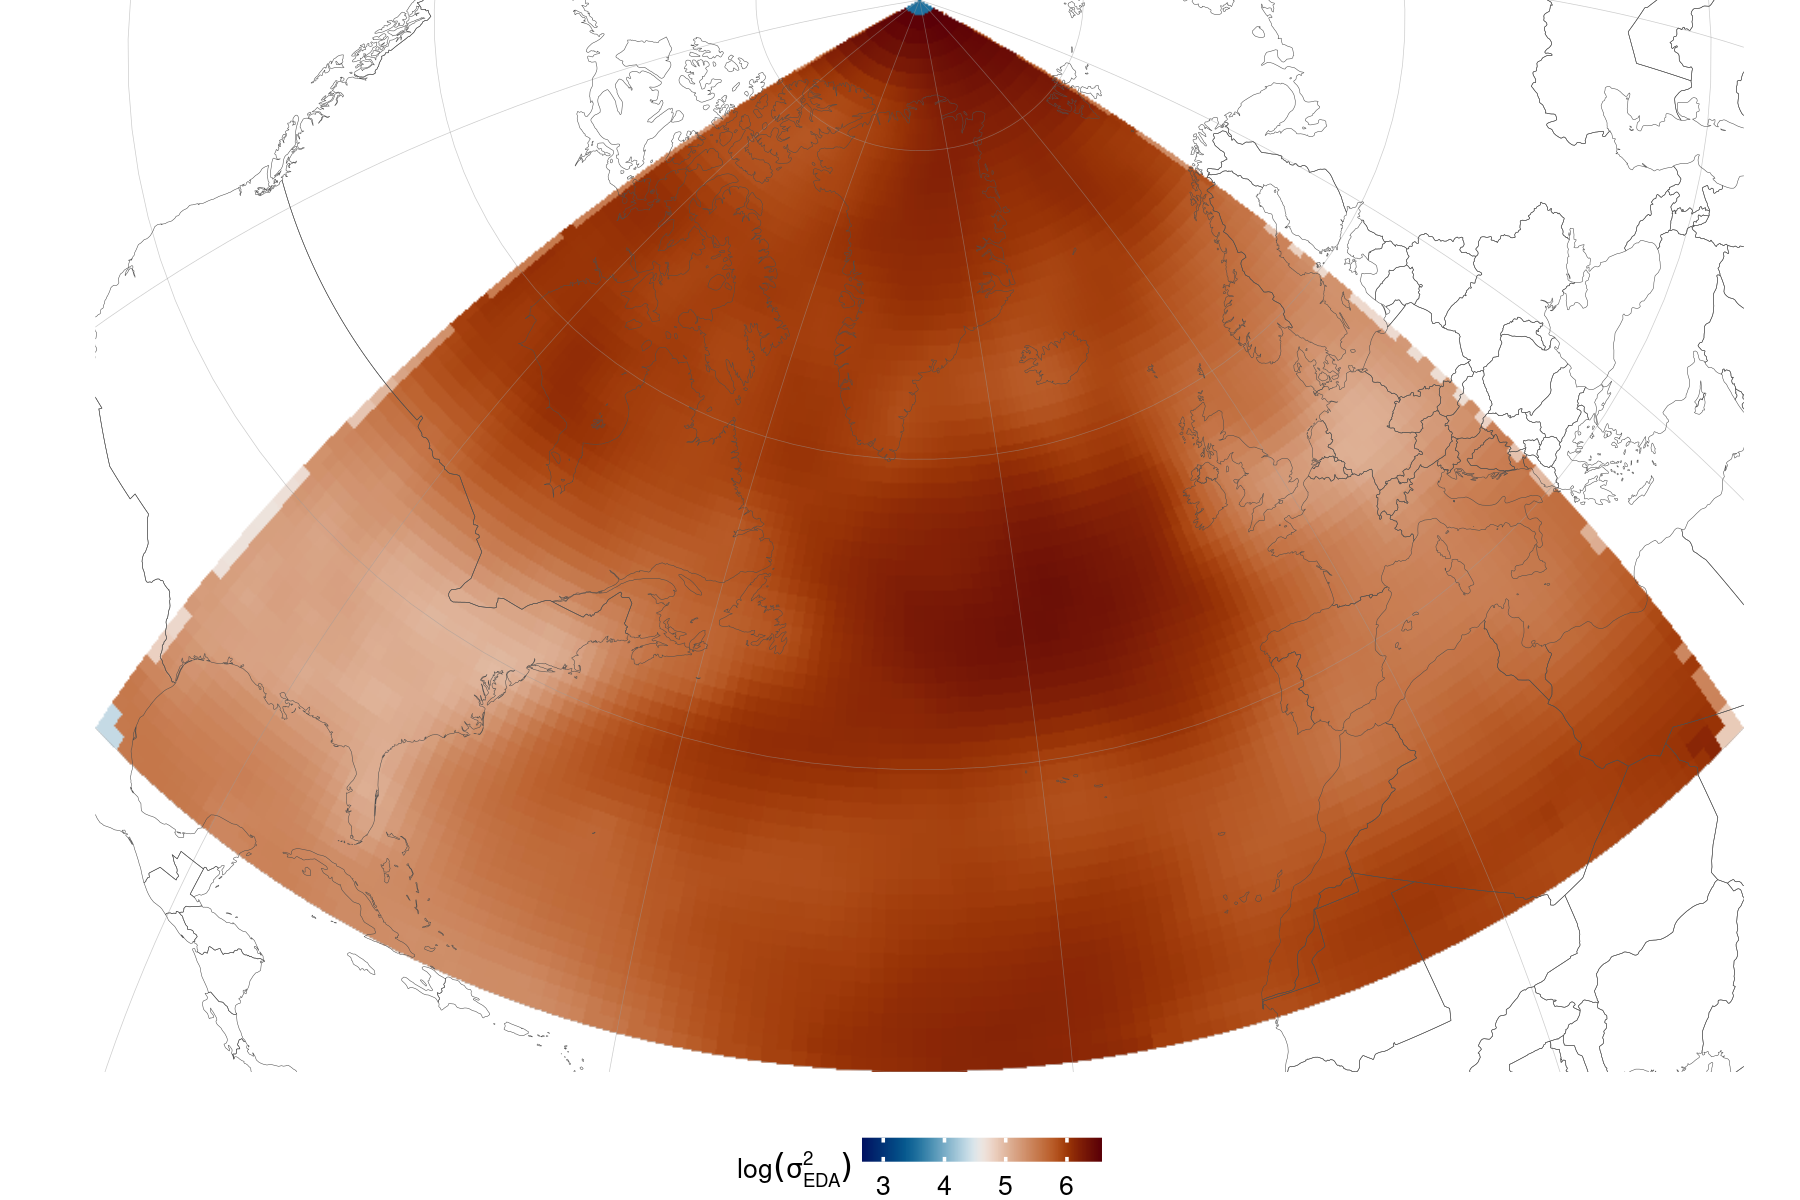

In [30]:
wr_df_i <- raw_total %>%
    filter(wr == 1)
wrn <- raw_total$wrname[raw_total$wr == 1][1]

p <- plot_spatial(wr_df_i, "mean",
    legend_name = "$\\log(\\sigma^{2}_{EDA})$",
    sig_name = NULL,
    alpha = NULL,
    show_graticule_labels = FALSE,
    use_diverging = TRUE,
    clims = range(wr_df_i$mean)
) + THEME_PUB_LARGE +
    theme(
        axis.text.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks = element_blank(),
        legend.position = "bottom",
        plot.margin = margin(0, 0, 0, 0),
        panel.spacing = unit(0, "lines")
    ) + labs(title = wrn)
p
